In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.svm import SVR
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# S&P

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('all_stocks_5yr.csv')

# Remove rows with null values
data = data.dropna()

# Normalization/Standardization
# Scaling the data to a uniform range using Min-Max scaling
min_max_scaler = lambda x: (x - min(x)) / (max(x) - min(x))
data[['open', 'high', 'low', 'close', 'volume']] = data[['open', 'high', 'low', 'close', 'volume']].apply(min_max_scaler)

# Stationarization
# Differencing to achieve stationarity, let's take 'close' column as an example
data['close_diff'] = data['close'].diff()

# Logarithmic transformation if necessary
# data['close_log'] = np.log(data['close'])

# Print the preprocessed data
print(data.head())

# Save the preprocessed data to a new CSV file if needed
data.to_csv('preprocessed_data.csv', index=False)


         date      open      high       low     close    volume Name  \
0  2013-02-08  0.006585  0.006500  0.006456  0.006428  0.013599  AAL   
1  2013-02-11  0.006497  0.006446  0.006275  0.006286  0.014366  AAL   
2  2013-02-12  0.006282  0.006204  0.006196  0.006193  0.013144  AAL   
3  2013-02-13  0.006208  0.006412  0.006270  0.006384  0.016595  AAL   
4  2013-02-14  0.006522  0.006422  0.005734  0.006056  0.051566  AAL   

   close_diff  
0         NaN  
1   -0.000142  
2   -0.000093  
3    0.000190  
4   -0.000327  


# Arima

Stationarity test for close_diff column:
ADF Statistic: -78.62140721500687
p-value: 0.0
Critical Values:
	1%: -3.430360565706588
	5%: -2.861544669919927
	10%: -2.5667724856274456
Stationary (Reject Null Hypothesis)


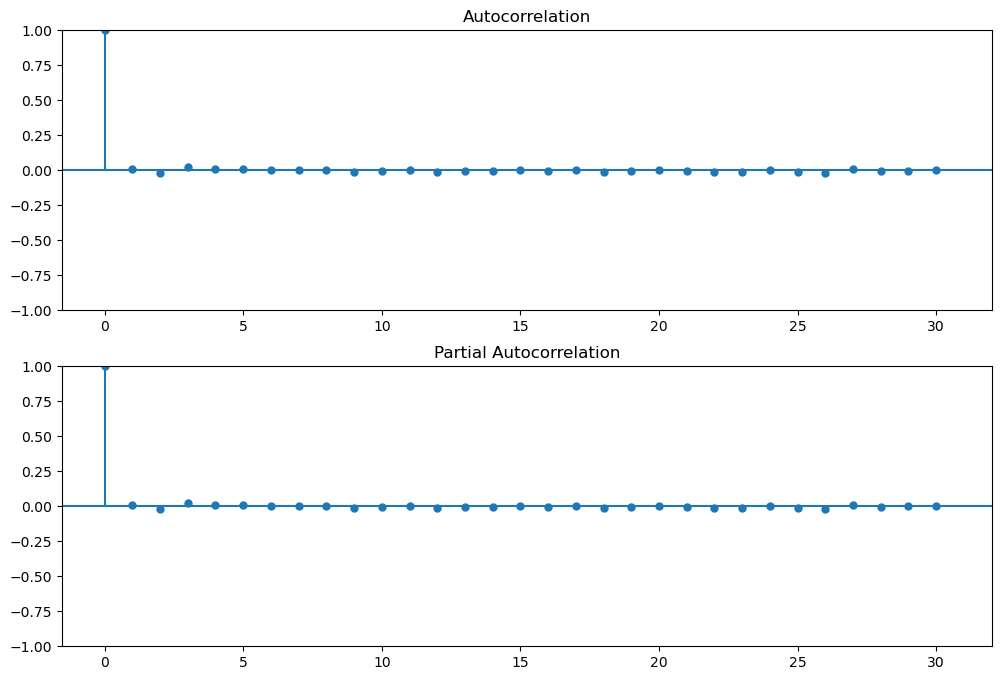

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:               619028
Model:                 ARIMA(1, 1, 1)   Log Likelihood             2868564.074
Date:                Fri, 10 May 2024   AIC                       -5737122.149
Time:                        20:36:46   BIC                       -5737088.141
Sample:                             0   HQIC                      -5737112.606
                             - 619028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0029      0.000      9.537      0.000       0.002       0.004
ma.L1         -0.9995      0.002   -522.272      0.000      -1.003      -0.996
sigma2      5.466e-06   1.01e-08    543.423      0.0

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')

# Check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('Stationary (Reject Null Hypothesis)')
    else:
        print('Non-Stationary (Fail to Reject Null Hypothesis)')

# Check stationarity of close_diff column
print("Stationarity test for close_diff column:")
check_stationarity(data['close_diff'].dropna())

# Plot ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['close_diff'].dropna(), ax=ax[0], lags=30)
plot_pacf(data['close_diff'].dropna(), ax=ax[1], lags=30)
plt.show()

# Fit ARIMA model
# Example: ARIMA(1, 1, 1)
arima_model = ARIMA(data['close_diff'].dropna(), order=(1, 1, 1))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Forecast using the ARIMA model
forecast = arima_result.forecast(steps=10)  # Example: Forecasting 10 steps ahead
print("Forecasted values:", forecast)


# ANN

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')

# Prepare the data
X = data[['open', 'high', 'low', 'close', 'volume']]  # Input features
y = data['close']  # Target variable

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Architecture Design
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Model Compilation
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')


Epoch 1/50


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12381/12381 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 8.8826e-06 - mae: 6.9935e-04 - val_loss: 4.0809e-07 - val_mae: 5.3464e-04
Epoch 2/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 6.6606e-07 - mae: 4.3231e-04 - val_loss: 1.5870e-06 - val_mae: 5.5362e-04
Epoch 3/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 6.7281e-07 - mae: 3.9466e-04 - val_loss: 8.8906e-08 - val_mae: 1.5072e-04
Epoch 4/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 3.9824e-07 - mae: 3.1522e-04 - val_loss: 1.0383e-06 - val_mae: 5.7774e-04
Epoch 5/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.2802e-07 - mae: 3.1480e-04 - val_loss: 9.0201e-08 - val_mae: 1.9910e-04
Epoch 6/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 3.2324e-07 - mae: 3.0424e-04 - val_loss: 5.5251e-07 - val_mae: 4.0370e-04
Epoch 7/50
12381/12381 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 5.1941e-07 - mae: 3.0292e-04 - val_loss: 6.6327e-08 - val_mae: 1.5652e-04
Epoch 8/50
12381/12381 ━━━━━━━━━━━━━━━

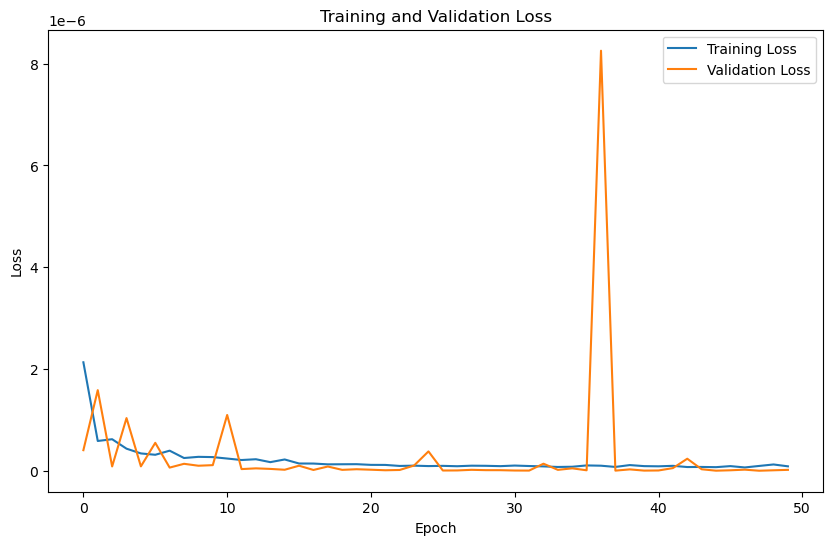

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Sarima

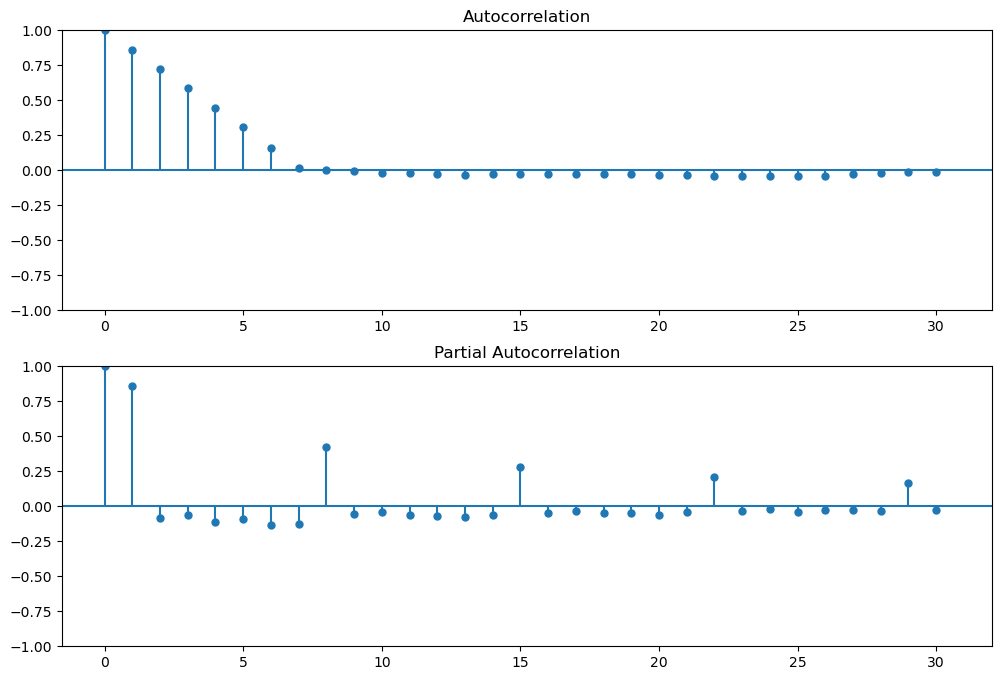

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-

MemoryError: Unable to allocate 1.33 GiB for an array with shape (619029, 17, 17) and data type float64

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Seasonal Differencing
seasonal_diff = data['close'].diff(periods=7)  # Example: Seasonal differencing with a period of 7 (weekly data)

# Plot ACF and PACF for seasonal differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_diff.dropna(), ax=ax[0], lags=30)
plot_pacf(seasonal_diff.dropna(), ax=ax[1], lags=30)
plt.show()

# Fit SARIMA model
# Example: SARIMA(1, 1, 1)x(1, 1, 1, 7) for non-seasonal and seasonal parameters
sarima_model = SARIMAX(data['close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()

# Forecasting
forecast = sarima_result.get_forecast(steps=10)  # Example: Forecasting 10 steps ahead
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Accuracy
mse = mean_squared_error(data['close'][-10:], forecast_mean)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the forecast and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Actual')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


# Exponential Smoothing (ETS) 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit ETS model
ets_model = ExponentialSmoothing(train_data['close'], trend='add', seasonal='add', seasonal_periods=7)  # Example: Additive seasonality with a period of 7 (weekly data)
ets_result = ets_model.fit()

# Forecasting
forecast = ets_result.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['close'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available

Root Mean Squared Error (RMSE): 0.1102638549816043


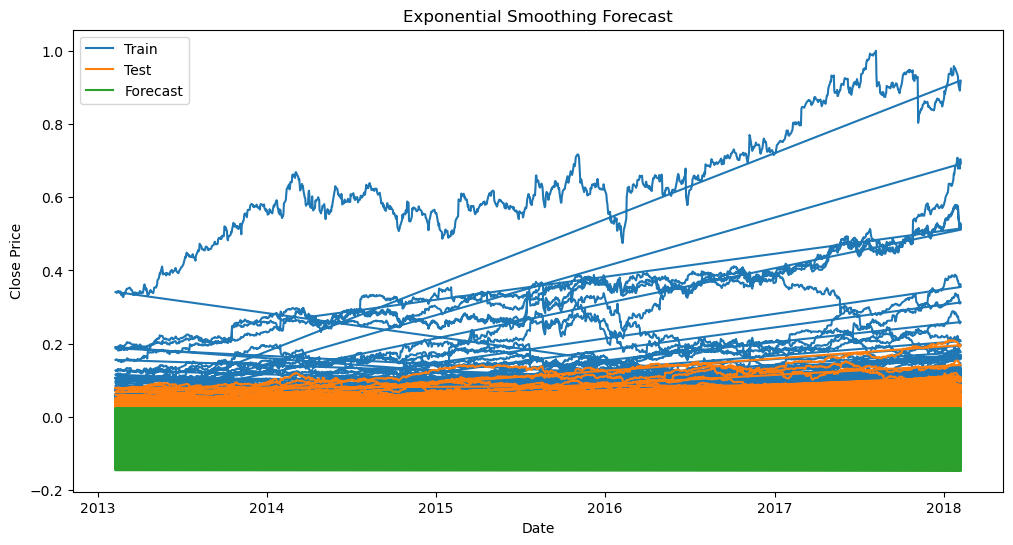

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['close'], label='Train')
plt.plot(test_data.index, test_data['close'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

# Prophet

13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


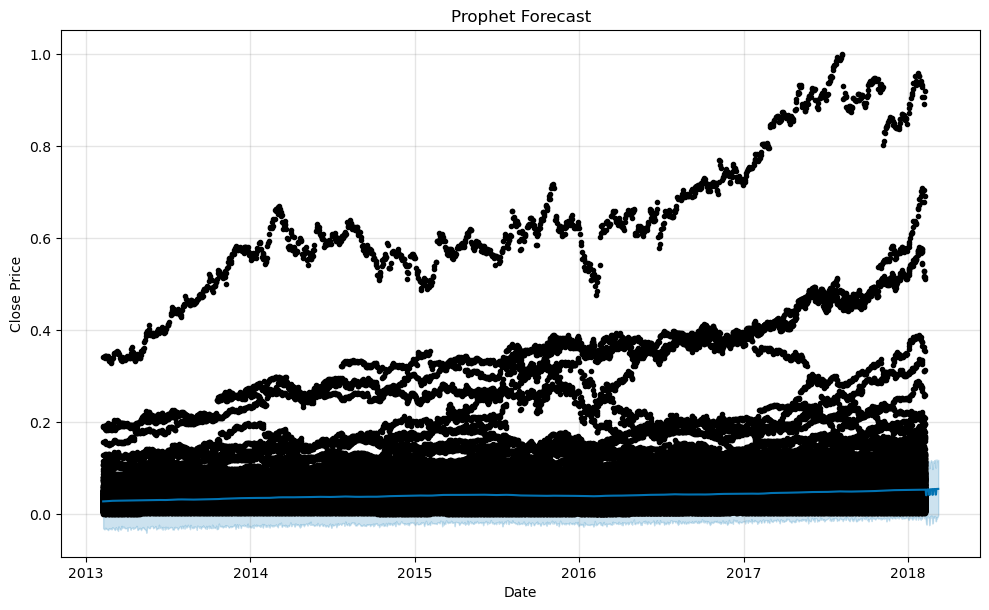

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_data.csv')
f_data['Date'] = pd.to_datetime(f_data['date'])

# Prepare the data for Prophet
f_data_prophet = f_data[['Date', 'close']].rename(columns={'Date': 'ds', 'close': 'y'})

# Define and fit the Prophet model
model = Prophet()
model.fit(f_data_prophet)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Forecast')
plt.show()


# SVR

Mean squared error: 0.007951969156808614


ValueError: x and y must be the same size

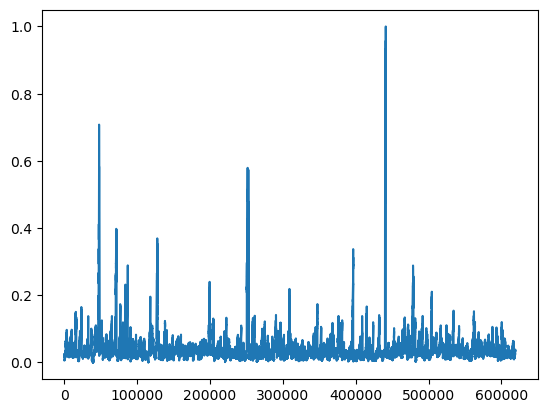

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_data.csv')

# Prepare the data
X = f_data[['open', 'high', 'low']].values
y = f_data['close'].values

# Define SVR function
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

# Fit SVR model
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)

# Predict the last value
X_pred = f_data[['open', 'high', 'low']].tail(1).values
y_pred = model.predict(X_pred)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

# Print Mean Squared Error
print('Mean squared error:', np.mean(scores))

# Plot the results
plt.plot(f_data.index, f_data['close'], label='Original data')
plt.scatter(f_data.index[-1], y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM

Epoch 1/10


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15476/15476 ━━━━━━━━━━━━━━━━━━━━ 103s 6ms/step - loss: 1.1310e-04
Epoch 2/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - loss: 6.4931e-05
Epoch 3/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - loss: 5.9800e-05
Epoch 4/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 5.7882e-05
Epoch 5/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - loss: 5.4258e-05
Epoch 6/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 5.8073e-05
Epoch 7/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - loss: 5.5110e-05
Epoch 8/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step - loss: 5.6928e-05
Epoch 9/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 102s 7ms/step - loss: 5.3223e-05
Epoch 10/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 103s 7ms/step - loss: 5.5822e-05
3869/3869 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step
Stock Price Forecast with LSTM - Mean Squared Error: 4.8134546476607756e-06


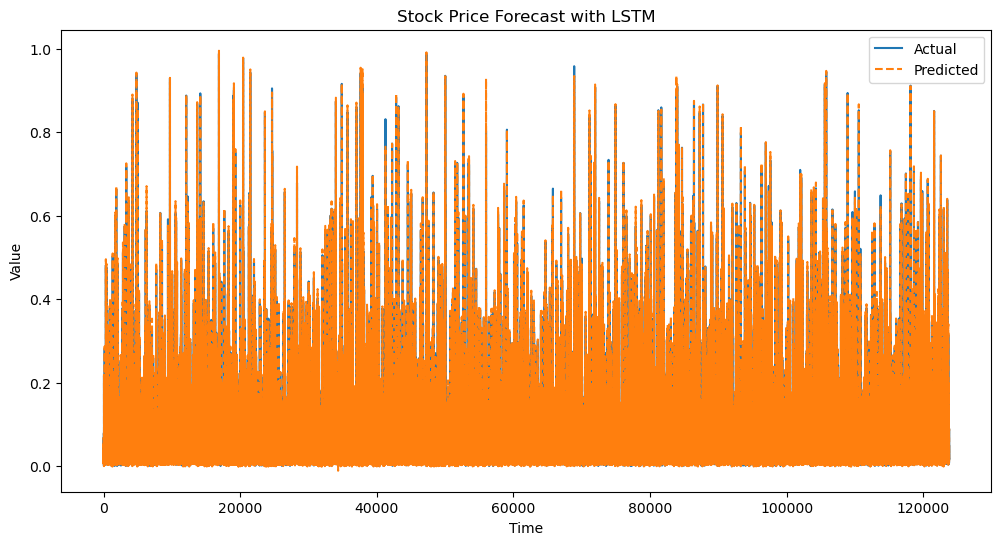

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_data.csv')

# Function to prepare data for LSTM
def prepare_lstm_data(df, feature, lookback=5):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[feature]])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to [samples, timesteps, features]
    return X, y, scaler

# Function to create and train LSTM model
def train_lstm_model(X_train, y_train, input_shape, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate LSTM model and plot results
def evaluate_lstm_model(model, X_test, y_test, scaler, title):
    y_pred = model.predict(X_test)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_scaled = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    print(f"{title} - Mean Squared Error: {mse}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_scaled, label='Actual')
    plt.plot(y_pred_scaled, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for LSTM
X, y, scaler = prepare_lstm_data(f_data, 'close', lookback=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LSTM model
lstm_model = train_lstm_model(X_train, y_train, (X_train.shape[1], 1))

# Evaluate LSTM model
evaluate_lstm_model(lstm_model, X_test, y_test, scaler, "Stock Price Forecast with LSTM")


# HYBRID

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 1.2133e-04
Epoch 2/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.2189e-04
Epoch 3/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 6.7679e-05
Epoch 4/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.5353e-04
Epoch 5/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 3.8794e-05
Epoch 6/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 2.5319e-05
Epoch 7/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.2646e-05
Epoch 8/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.9965e-05
Epoch 9/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 7.7059e-06
Epoch 10/10
15476/15476 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 6.0728e-06
3869/3869 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Hybrid ARIMA-ANN Forecast - Mean Squared Error: 3.479161001016277e-06, Mean Absolute Error: 0.0005448187395121109


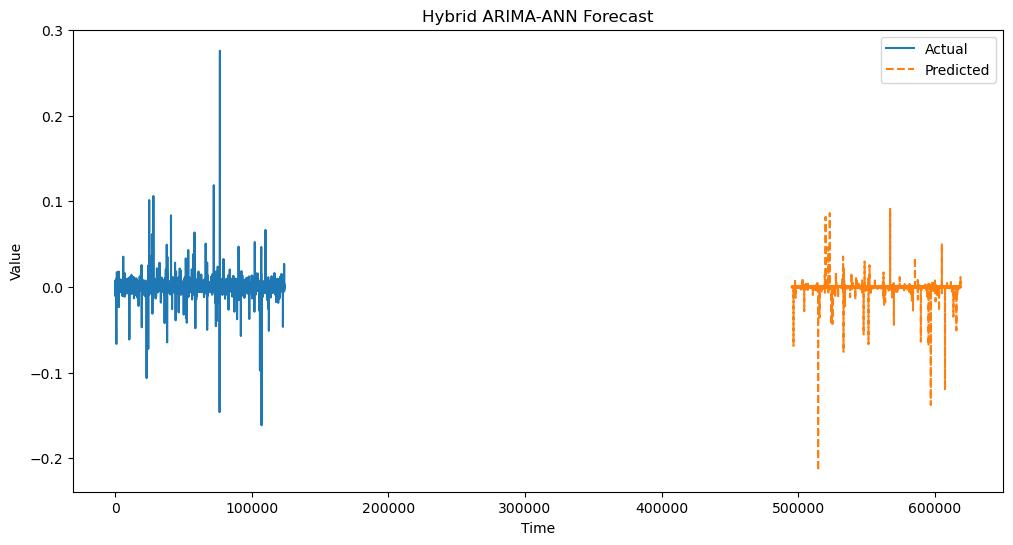

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load data (update file paths as needed)
f_data = pd.read_csv('preprocessed_data.csv')

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# Log Transformation and Differencing
f_data['close_log'] = np.log(f_data['close'] + 1)
f_data['close_diff'] = f_data['close_log'].diff().dropna()
f_data_stationarity = test_stationarity(f_data['close_diff'].dropna())

# Function to prepare data for ARIMA
def prepare_arima_data(df, feature):
    return df[[feature]].dropna()

# Function to create and train an ARIMA model
def train_arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit()
    return model_fit

# Function to create and train an ANN model
def train_ann_model(X_train, y_train, input_dim, epochs=10, batch_size=32):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for ARIMA
f_data_for_arima = prepare_arima_data(f_data, 'close_diff')
arima_model = train_arima_model(f_data_for_arima, order=(5, 1, 0))
arima_pred = arima_model.predict(start=0, end=len(f_data_for_arima)-1)
residuals = f_data_for_arima['close_diff'] - arima_pred

# ANN model for residuals
scaler = StandardScaler()
X = scaler.fit_transform(arima_pred.values.reshape(-1, 1))
y = residuals.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ann_model = train_ann_model(X_train, y_train, input_dim=1)
ann_pred = ann_model.predict(X_test)

# Combine ARIMA and ANN predictions
combined_pred = arima_pred[-len(ann_pred):] + ann_pred.flatten()
evaluate_hybrid_model(y_test, combined_pred, "Hybrid ARIMA-ANN Forecast")


# Enviromental Sector

In [21]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('archive.csv')

# Cleaning: Remove rows with null values
data.dropna(inplace=True)

# Normalization/Standardization: Scaling the data to a uniform range using Min-Max scaling
min_max_scaler = lambda x: (x - min(x)) / (max(x) - min(x))
data[['Carbon Dioxide (ppm)', 'Seasonally Adjusted CO2 (ppm)', 'Carbon Dioxide Fit (ppm)', 'Seasonally Adjusted CO2 Fit (ppm)']] = \
    data[['Carbon Dioxide (ppm)', 'Seasonally Adjusted CO2 (ppm)', 'Carbon Dioxide Fit (ppm)', 'Seasonally Adjusted CO2 Fit (ppm)']].apply(min_max_scaler)

# Stationarization: Differencing to achieve stationarity
data['Carbon Dioxide (ppm)_diff'] = data['Carbon Dioxide (ppm)'].diff()
data['Seasonally Adjusted CO2 (ppm)_diff'] = data['Seasonally Adjusted CO2 (ppm)'].diff()
data['Carbon Dioxide Fit (ppm)_diff'] = data['Carbon Dioxide Fit (ppm)'].diff()
data['Seasonally Adjusted CO2 Fit (ppm)_diff'] = data['Seasonally Adjusted CO2 Fit (ppm)'].diff()

# Logarithmic transformation if necessary
# data['close_log'] = np.log(data['close'])

# Print the preprocessed data
print(data.head())

# Save the preprocessed data to a new CSV file if needed
data.to_csv('preprocessed_archive.csv', index=False)


   Year  Month  Decimal Date  Carbon Dioxide (ppm)  \
2  1958      3     1958.2027              0.026260   
3  1958      4     1958.2877              0.044896   
4  1958      5     1958.3699              0.045426   
6  1958      7     1958.5370              0.028060   
7  1958      8     1958.6219              0.018213   

   Seasonally Adjusted CO2 (ppm)  Carbon Dioxide Fit (ppm)  \
2                       0.000000                  0.039030   
3                       0.007968                  0.050844   
4                       0.003384                  0.056435   
6                       0.008186                  0.035759   
7                       0.019101                  0.016139   

   Seasonally Adjusted CO2 Fit (ppm)  Carbon Dioxide (ppm)_diff  \
2                           0.000000                        NaN   
3                           0.000990                   0.018636   
4                           0.001869                   0.000529   
6                           0.0035

# Arima

Stationarity test for Carbon Dioxide (ppm) column:
ADF Statistic: 4.266681625489794
p-value: 1.0
Critical Values:
	1%: -3.439960610754265
	5%: -2.8657809735786244
	10%: -2.5690284373908066
Non-Stationary (Fail to Reject Null Hypothesis)


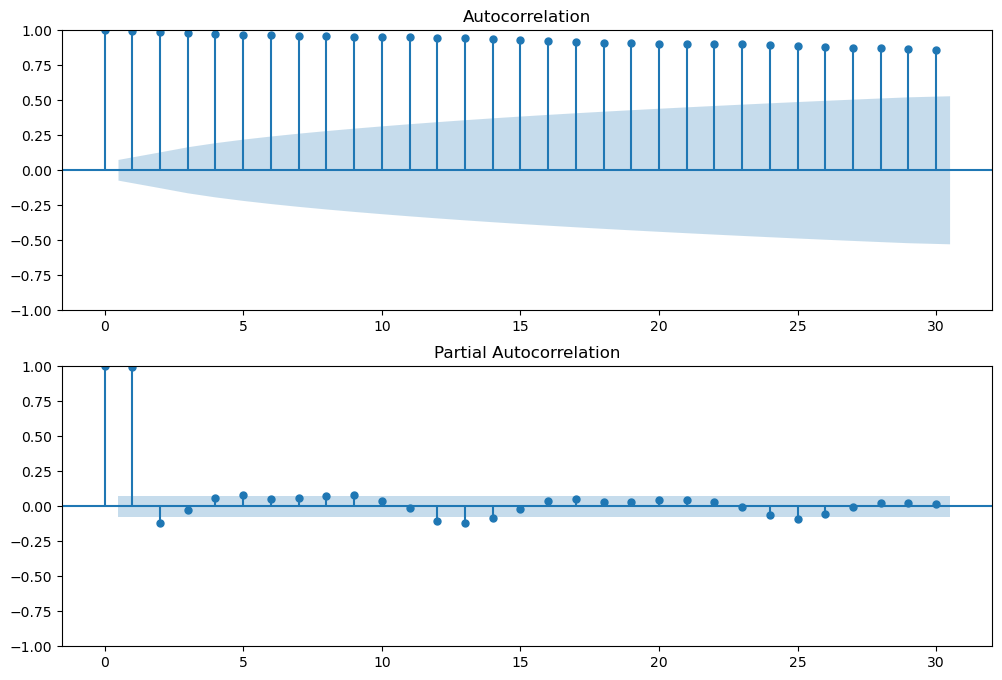

                                SARIMAX Results                                 
Dep. Variable:     Carbon Dioxide (ppm)   No. Observations:                  702
Model:                   ARIMA(1, 1, 1)   Log Likelihood                2308.321
Date:                  Sat, 11 May 2024   AIC                          -4610.642
Time:                          16:05:59   BIC                          -4596.984
Sample:                               0   HQIC                         -4605.363
                                  - 702                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5687      0.043     13.371      0.000       0.485       0.652
ma.L1          0.3170      0.051      6.239      0.000       0.217       0.417
sigma2      8.065e-05   5.13e-06    

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load the preprocessed data
data = pd.read_csv('preprocessed_archive.csv')

# Check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('Stationary (Reject Null Hypothesis)')
    else:
        print('Non-Stationary (Fail to Reject Null Hypothesis)')

# Check stationarity of Carbon Dioxide (ppm) column
print("Stationarity test for Carbon Dioxide (ppm) column:")
check_stationarity(data['Carbon Dioxide (ppm)'].dropna())

# Plot ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Carbon Dioxide (ppm)'].dropna(), ax=ax[0], lags=30)
plot_pacf(data['Carbon Dioxide (ppm)'].dropna(), ax=ax[1], lags=30)
plt.show()

# Fit ARIMA model
# Example: ARIMA(1, 1, 1)
arima_model = ARIMA(data['Carbon Dioxide (ppm)'].dropna(), order=(1, 1, 1))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Forecast using the ARIMA model
forecast = arima_result.forecast(steps=10)  # Example: Forecasting 10 steps ahead
print("Forecasted values:", forecast)


# ANN

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# Load the preprocessed data
data = pd.read_csv('preprocessed_archive.csv')

# Prepare the data
X = data[['Carbon Dioxide (ppm)', 'Seasonally Adjusted CO2 (ppm)', 'Carbon Dioxide Fit (ppm)', 'Seasonally Adjusted CO2 Fit (ppm)']]  # Input features
y = data['Carbon Dioxide (ppm)']  # Target variable

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Architecture Design
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Model Compilation
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')


Epoch 1/50


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0348 - mae: 0.1386 - val_loss: 0.0054 - val_mae: 0.0711
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mae: 0.0599 - val_loss: 8.4635e-04 - val_mae: 0.0249
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9357e-04 - mae: 0.0238 - val_loss: 2.7606e-04 - val_mae: 0.0134
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8008e-04 - mae: 0.0129 - val_loss: 1.3779e-04 - val_mae: 0.0097
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7301e-04 - mae: 0.0108 - val_loss: 1.2497e-04 - val_mae: 0.0095
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2046e-04 - mae: 0.0091 - val_loss: 1.0228e-04 - val_mae: 0.0087
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0967e-04 - mae: 0.0087 - val_loss: 9.9737e-05 - val_mae: 0.0086
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4666e-05 - mae: 0.0083 - val_loss: 8.4255e-05 - val_mae: 0.0079
Epoch 9/50
14/14 ━━━━━━━━━━━━

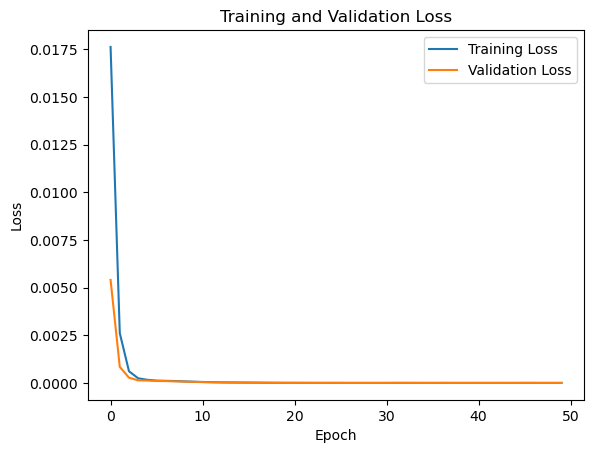

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# SARIMA

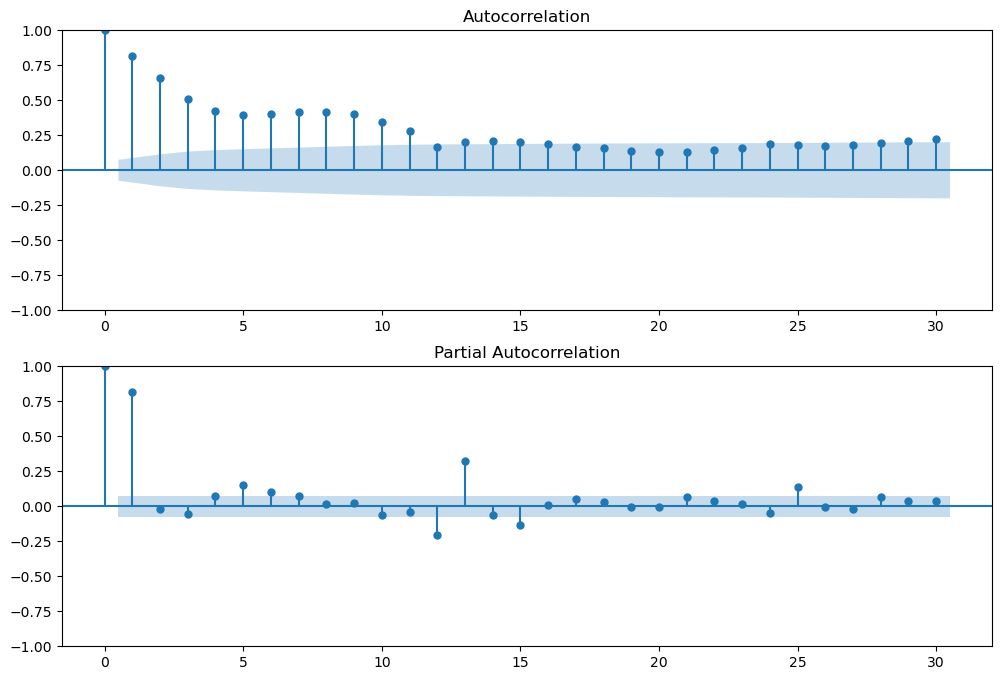

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\

Root Mean Squared Error (RMSE): 0.04368027876700175


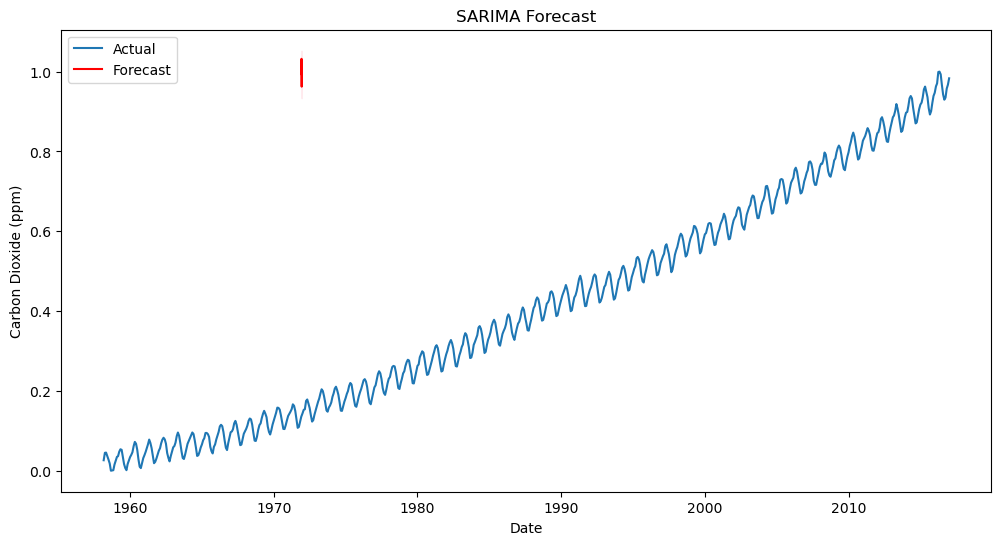

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_archive.csv')
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(Day=1))
data.set_index('Date', inplace=True)

# Seasonal Differencing
seasonal_diff = data['Carbon Dioxide (ppm)'].diff(periods=12)  # Example: Seasonal differencing with a period of 12 (monthly data)

# Plot ACF and PACF for seasonal differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_diff.dropna(), ax=ax[0], lags=30)
plot_pacf(seasonal_diff.dropna(), ax=ax[1], lags=30)
plt.show()

# Fit SARIMA model
# Example: SARIMA(1, 1, 1)x(1, 1, 1, 12) for non-seasonal and seasonal parameters
sarima_model = SARIMAX(data['Carbon Dioxide (ppm)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Forecasting
forecast = sarima_result.get_forecast(steps=10)  # Example: Forecasting 10 steps ahead
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Accuracy
mse = mean_squared_error(data['Carbon Dioxide (ppm)'][-10:], forecast_mean)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the forecast and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Carbon Dioxide (ppm)'], label='Actual')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Carbon Dioxide (ppm)')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


# ETS

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_archive.csv')
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(Day=1))
data.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit ETS model
ets_model = ExponentialSmoothing(train_data['Carbon Dioxide (ppm)'], trend='add', seasonal='add', seasonal_periods=12)  # Example: Additive seasonality with a period of 12 (monthly data)
ets_result = ets_model.fit()

# Forecasting
forecast = ets_result.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['Carbon Dioxide (ppm)'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)


C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Root Mean Squared Error (RMSE): 0.03622988154310654


C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


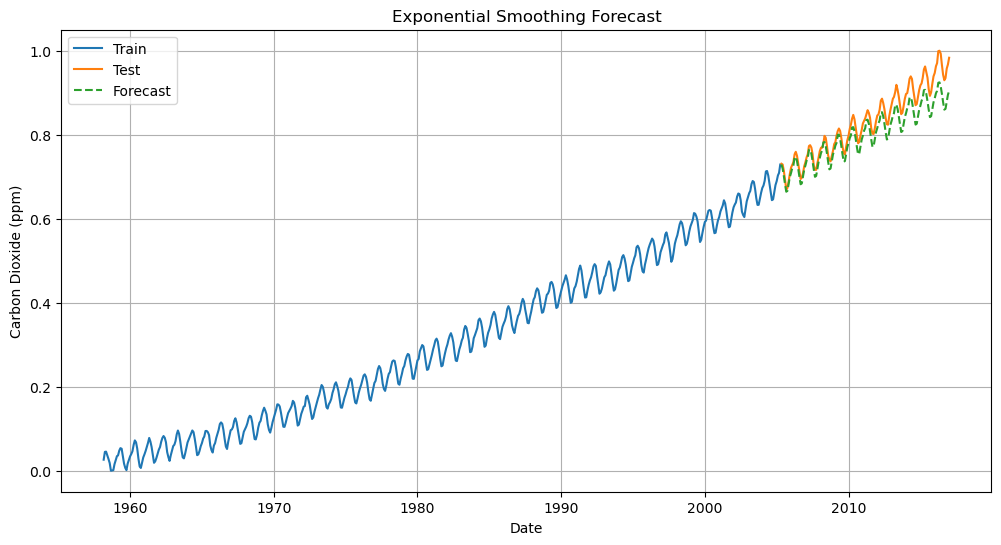

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Carbon Dioxide (ppm)'], label='Train')
plt.plot(test_data.index, test_data['Carbon Dioxide (ppm)'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Carbon Dioxide (ppm)')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.grid(True)
plt.show()


# Prophet

20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:46 - cmdstanpy - INFO - Chain [1] done processing


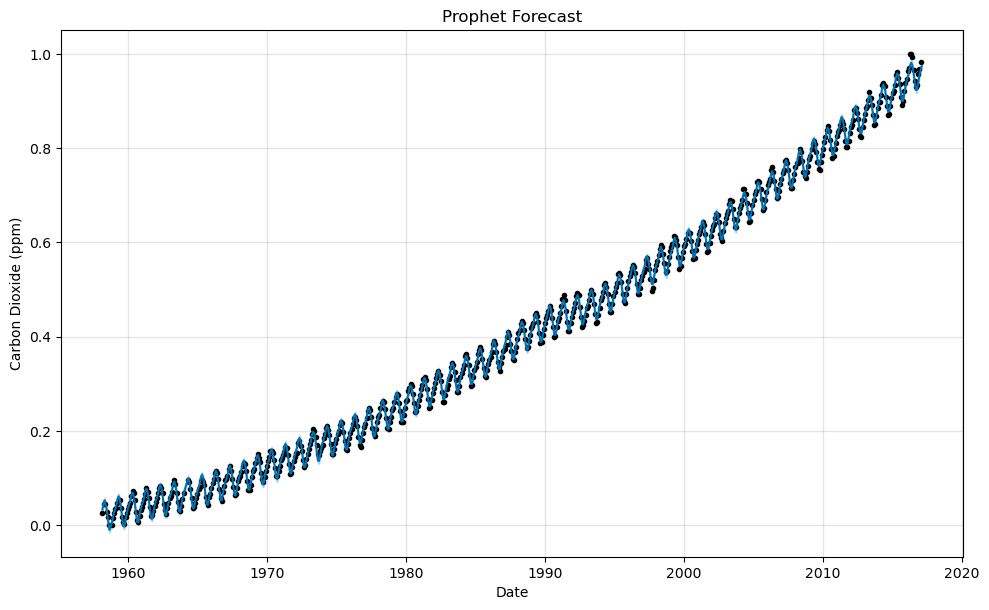

In [28]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_archive.csv')
f_data['Date'] = pd.to_datetime(f_data[['Year', 'Month']].assign(Day=1))

# Prepare the data for Prophet
f_data_prophet = f_data[['Date', 'Carbon Dioxide (ppm)']].rename(columns={'Date': 'ds', 'Carbon Dioxide (ppm)': 'y'})

# Define and fit the Prophet model
model = Prophet()
model.fit(f_data_prophet)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Carbon Dioxide (ppm)')
plt.title('Prophet Forecast')
plt.show()


# Support Vector Regression (SVR):

Mean squared error: 0.08918512311630622


ValueError: x and y must be the same size

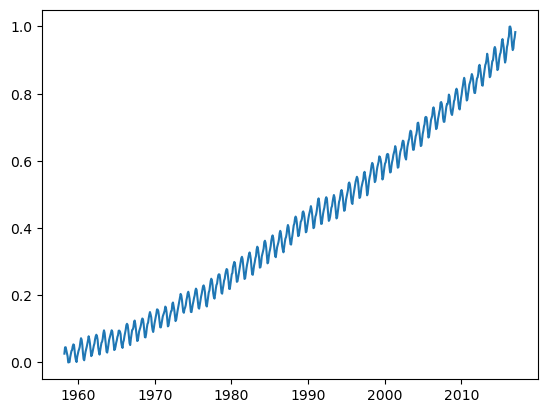

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_archive.csv')

# Prepare the data
X = f_data[['Decimal Date']].values
y = f_data['Carbon Dioxide (ppm)'].values

# Define SVR function
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

# Fit SVR model
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)

# Predict the last value
X_pred = f_data[['Decimal Date']].tail(1).values
y_pred = model.predict(X_pred)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

# Print Mean Squared Error
print('Mean squared error:', np.mean(scores))

# Plot the results
plt.plot(f_data['Decimal Date'], f_data['Carbon Dioxide (ppm)'], label='Original data')
plt.scatter(f_data['Decimal Date'].iloc[-1], y_pred, color='red', label='Predicted value')
plt.xlabel('Decimal Date')
plt.ylabel('Carbon Dioxide (ppm)')
plt.title('SVR Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Long Short-Term Memory (LSTM):

C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3039
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1598
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0620
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Carbon Dioxide Forecast with LSTM - Mean Squared Error: 0.0008829893456366202


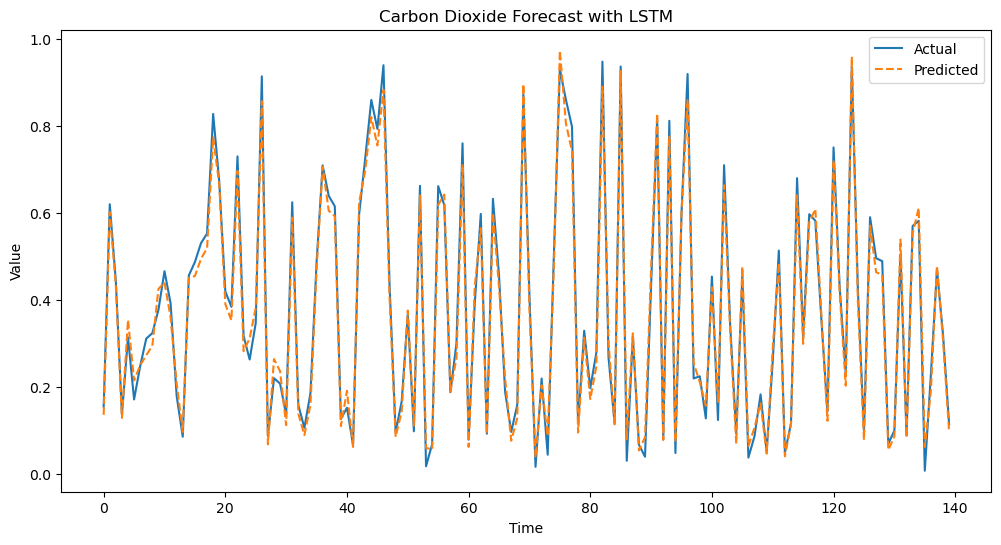

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_archive.csv')

# Function to prepare data for LSTM
def prepare_lstm_data(df, feature, lookback=5):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[feature]])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to [samples, timesteps, features]
    return X, y, scaler

# Function to create and train LSTM model
def train_lstm_model(X_train, y_train, input_shape, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate LSTM model and plot results
def evaluate_lstm_model(model, X_test, y_test, scaler, title):
    y_pred = model.predict(X_test)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_scaled = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    print(f"{title} - Mean Squared Error: {mse}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_scaled, label='Actual')
    plt.plot(y_pred_scaled, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for LSTM
X, y, scaler = prepare_lstm_data(f_data, 'Carbon Dioxide (ppm)', lookback=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LSTM model
lstm_model = train_lstm_model(X_train, y_train, (X_train.shape[1], 1))

# Evaluate LSTM model
evaluate_lstm_model(lstm_model, X_test, y_test, scaler, "Carbon Dioxide Forecast with LSTM")


# Hybrid

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/50


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013     
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1496e-04 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6747e-04 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6225e-04  
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7836e-04 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1375e-04 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5443e-04 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0457e-04 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7458e-05 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4247e-05 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7567e-05 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1804e-05 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7354e-05 
Epoch 15/50
18/18 ━━━━━━━━━━━━

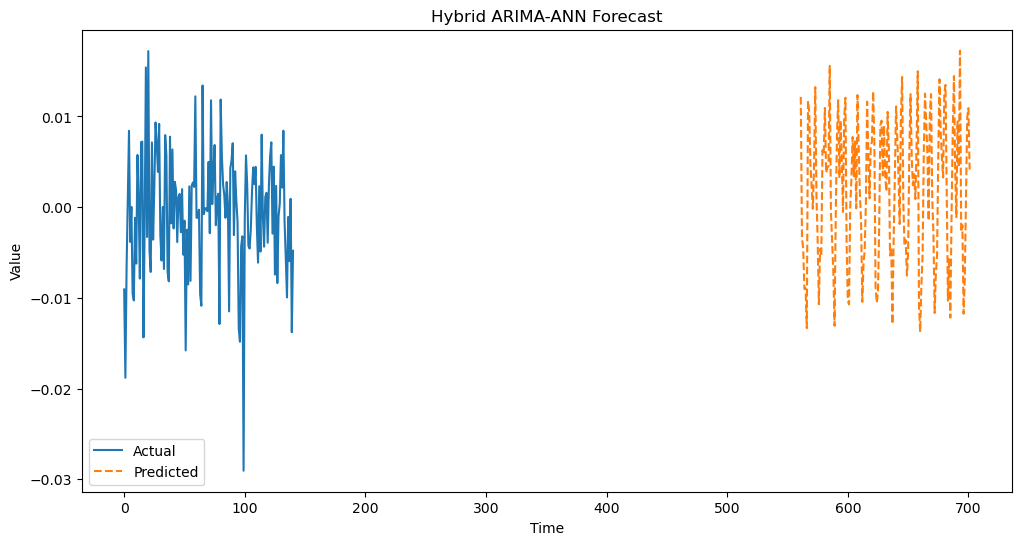

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load data
archive_data = pd.read_csv('preprocessed_archive.csv')

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# Log Transformation and Differencing
archive_data['Carbon Dioxide (ppm)_log'] = np.log(archive_data['Carbon Dioxide (ppm)'] + 1)
archive_data['Carbon Dioxide (ppm)_diff'] = archive_data['Carbon Dioxide (ppm)_log'].diff().dropna()
archive_stationarity = test_stationarity(archive_data['Carbon Dioxide (ppm)_diff'].dropna())

# Function to prepare data for ARIMA
def prepare_arima_data(df, feature):
    return df[[feature]].dropna()

# Function to create and train an ARIMA model
def train_arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit()
    return model_fit

# Function to create and train an ANN model
def train_ann_model(X_train, y_train, input_dim, epochs=50, batch_size=32):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for ARIMA
archive_data_for_arima = prepare_arima_data(archive_data, 'Carbon Dioxide (ppm)_diff')
arima_model = train_arima_model(archive_data_for_arima, order=(5, 1, 0))
arima_pred = arima_model.predict(start=0, end=len(archive_data_for_arima)-1)
residuals = archive_data_for_arima['Carbon Dioxide (ppm)_diff'] - arima_pred

# ANN model for residuals
scaler = MinMaxScaler()
X = scaler.fit_transform(arima_pred.values.reshape(-1, 1))
y = residuals.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ann_model = train_ann_model(X_train, y_train, input_dim=1)
ann_pred = ann_model.predict(X_test)

# Combine ARIMA and ANN predictions
combined_pred = arima_pred[-len(ann_pred):] + ann_pred.flatten()
evaluate_hybrid_model(y_test, combined_pred, "Hybrid ARIMA-ANN Forecast")


# Energy Sector:

In [36]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('electricityConsumptionAndProductioction.csv')

# Convert DateTime column to datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Cleaning: Check for and handle missing values
data = data.dropna()

# Normalization/Standardization: Scale the numerical columns to a uniform range using Min-Max scaling
min_max_scaler = lambda x: (x - min(x)) / (max(x) - min(x))
numeric_columns = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
data[numeric_columns] = data[numeric_columns].apply(min_max_scaler)

# Stationarization: Apply differencing to achieve stationarity, if necessary
# Let's take 'Consumption' column as an example
data['Consumption_diff'] = data['Consumption'].diff()

# Logarithmic transformation if necessary
# data['Consumption_log'] = np.log(data['Consumption'])

# Print the preprocessed data
print(data.head())

# Save the preprocessed data to a new CSV file if needed
data.to_csv('preprocessed_electricity_data.csv', index=False)


             DateTime  Consumption  Production   Nuclear      Wind  \
0 2019-01-01 00:00:00     0.430143    0.488814  0.930726  0.037011   
1 2019-01-01 01:00:00     0.388928    0.363111  0.928492  0.043003   
2 2019-01-01 02:00:00     0.346490    0.359306  0.928492  0.059217   
3 2019-01-01 03:00:00     0.313133    0.348197  0.932961  0.076489   
4 2019-01-01 04:00:00     0.291303    0.325521  0.928492  0.065210   

   Hydroelectric  Oil and Gas      Coal  Solar   Biomass  Consumption_diff  
0       0.283635     0.873906  0.648804    0.0  0.180556               NaN  
1       0.220005     0.633556  0.603189    0.0  0.180556         -0.041216  
2       0.200751     0.652084  0.592117    0.0  0.180556         -0.042438  
3       0.187133     0.646938  0.566430    0.0  0.180556         -0.033357  
4       0.184316     0.646423  0.522143    0.0  0.180556         -0.021830  


# Arima

Stationarity test for Consumption_diff column:
ADF Statistic: -36.83709885668122
p-value: 0.0
Critical Values:
	1%: -3.430492312043259
	5%: -2.861602898878345
	10%: -2.566803479013942
Stationary (Reject Null Hypothesis)


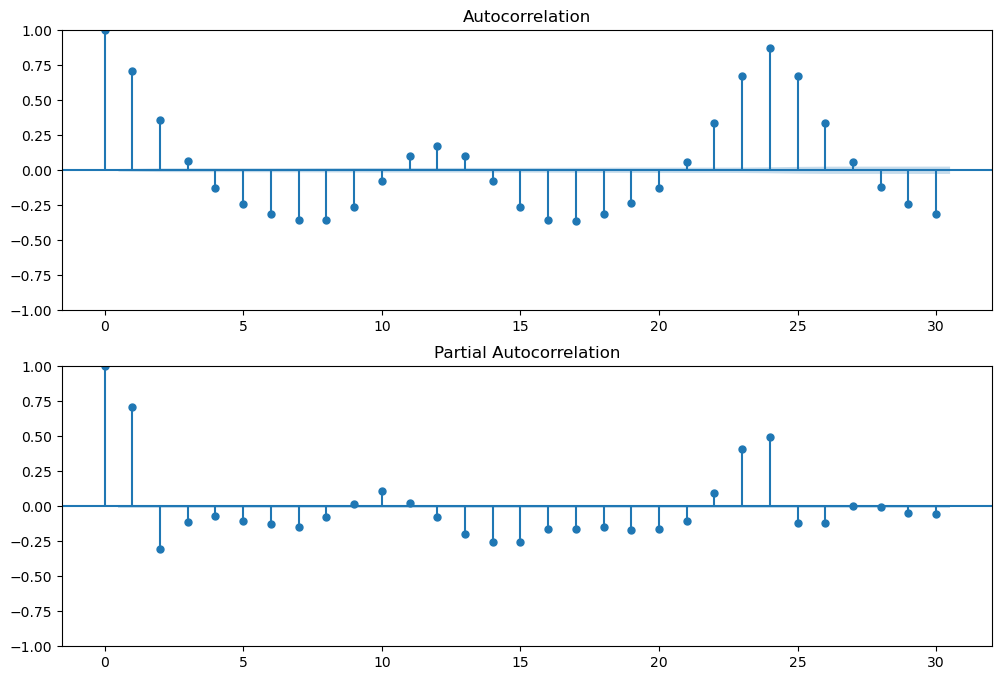

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Consumption_diff   No. Observations:                46010
Model:                 ARIMA(1, 1, 1)   Log Likelihood               85355.805
Date:                Sat, 11 May 2024   AIC                        -170705.610
Time:                        20:30:11   BIC                        -170679.400
Sample:                             0   HQIC                       -170697.368
                              - 46010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1870      0.031     -5.960      0.000      -0.248      -0.126
ma.L1          0.3182      0.030     10.558      0.000       0.259       0.377
sigma2         0.0014   7.14e-06    200.515      0.0

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load the preprocessed data
data = pd.read_csv('preprocessed_electricity_data.csv')

# Check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('Stationary (Reject Null Hypothesis)')
    else:
        print('Non-Stationary (Fail to Reject Null Hypothesis)')

# Check stationarity of Consumption_diff column
print("Stationarity test for Consumption_diff column:")
check_stationarity(data['Consumption_diff'].dropna())

# Plot ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Consumption_diff'].dropna(), ax=ax[0], lags=30)
plot_pacf(data['Consumption_diff'].dropna(), ax=ax[1], lags=30)
plt.show()

# Fit ARIMA model
# Example: ARIMA(1, 1, 1)
arima_model = ARIMA(data['Consumption_diff'].dropna(), order=(1, 1, 1))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Forecast using the ARIMA model
forecast = arima_result.forecast(steps=10)  # Example: Forecasting 10 steps ahead
print("Forecasted values:", forecast)


# ANN

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# Load the preprocessed data
data = pd.read_csv('preprocessed_electricity_data.csv')

# Prepare the data
X = data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']]  # Input features
y = data['Consumption']  # Target variable (can be adjusted if necessary)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Architecture Design
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Model Compilation
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')


Epoch 1/50


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


921/921 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0129 - mae: 0.0546 - val_loss: 5.7082e-05 - val_mae: 0.0054
Epoch 2/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.8415e-05 - mae: 0.0051 - val_loss: 1.7556e-05 - val_mae: 0.0029
Epoch 3/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9328e-05 - mae: 0.0032 - val_loss: 1.2089e-05 - val_mae: 0.0027
Epoch 4/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1371e-05 - mae: 0.0025 - val_loss: 4.8932e-06 - val_mae: 0.0016
Epoch 5/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.0724e-06 - mae: 0.0023 - val_loss: 6.0186e-06 - val_mae: 0.0021
Epoch 6/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.3726e-06 - mae: 0.0018 - val_loss: 1.8146e-05 - val_mae: 0.0041
Epoch 7/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4825e-06 - mae: 0.0022 - val_loss: 9.1112e-06 - val_mae: 0.0027
Epoch 8/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2671e-06 - mae: 0.0020 - val_loss: 1.8669e-06 - val_mae: 0.0010
Epoch 9

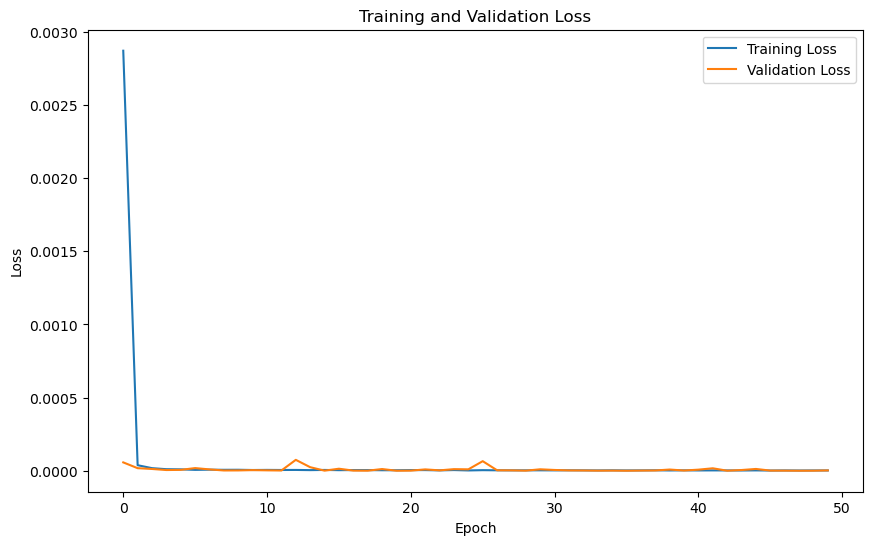

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Sarima

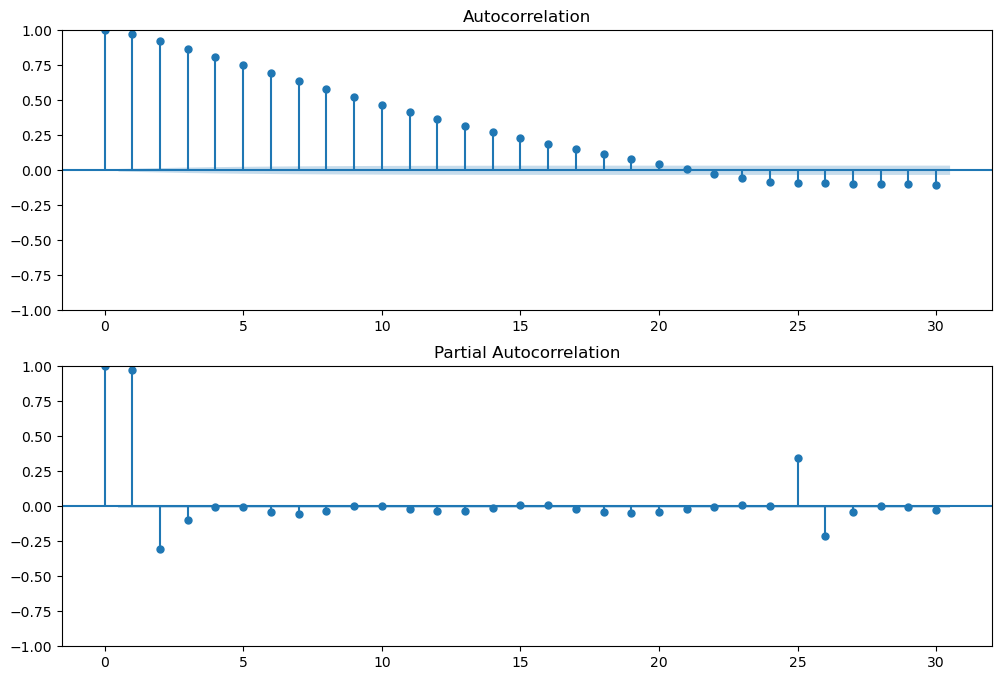

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_electricity_data.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Seasonal Differencing
seasonal_diff = data['Consumption'].diff(periods=24)  # Assuming hourly data with a daily seasonality (24 hours)

# Plot ACF and PACF for seasonal differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_diff.dropna(), ax=ax[0], lags=30)
plot_pacf(seasonal_diff.dropna(), ax=ax[1], lags=30)
plt.show()

# Fit SARIMA model
# Example: SARIMA(1, 1, 1)x(1, 1, 1, 24) for non-seasonal and seasonal parameters
sarima_model = SARIMAX(data['Consumption'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()

# Forecasting
forecast = sarima_result.get_forecast(steps=10)  # Example: Forecasting 10 steps ahead
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Accuracy
mse = mean_squared_error(data['Consumption'][-10:], forecast_mean)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the forecast and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Consumption'], label='Actual')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


# ETS

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the preprocessed data
data = pd.read_csv('preprocessed_electricity_data.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit ETS model
ets_model = ExponentialSmoothing(train_data['Consumption'], trend='add', seasonal='add', seasonal_periods=24)  # Assuming hourly data with a daily seasonality (24 hours)
ets_result = ets_model.fit()

# Forecasting
forecast = ets_result.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['Consumption'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)


C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error (RMSE): 0.1387849956533921


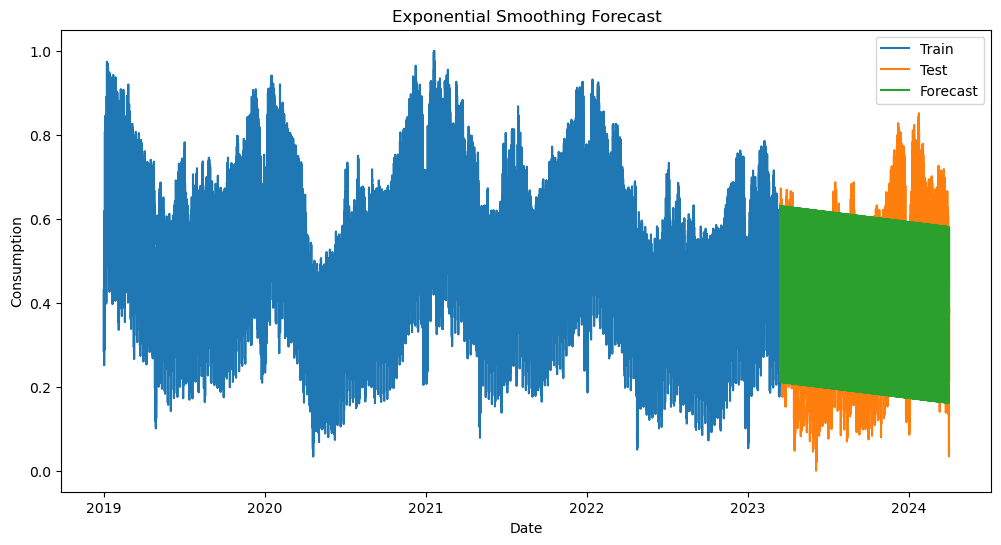

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Consumption'], label='Train')
plt.plot(test_data.index, test_data['Consumption'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()


# Prophet

20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing


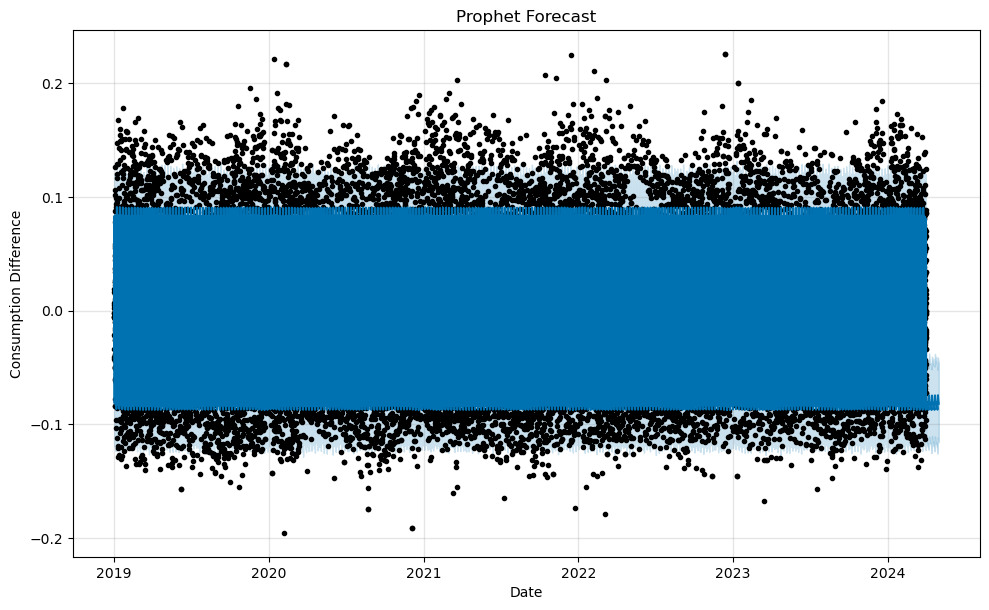

In [50]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_electricity_data.csv')
f_data['DateTime'] = pd.to_datetime(f_data['DateTime'])

# Prepare the data for Prophet
f_data_prophet = f_data[['DateTime', 'Consumption_diff']].rename(columns={'DateTime': 'ds', 'Consumption_diff': 'y'})

# Define and fit the Prophet model
model = Prophet()
model.fit(f_data_prophet)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Consumption Difference')
plt.title('Prophet Forecast')
plt.show()


# SVR

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_electricity_data.csv')

# Prepare the data
X = f_data[['Nuclear', 'Wind', 'Hydroelectric']].values
y = f_data['Consumption'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define SVR function
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

# Fit SVR model
model = svr(X_scaled, y, C=1.0, kernel='rbf', gamma=0.1)

# Predict the last value
X_pred = scaler.transform(f_data[['Nuclear', 'Wind', 'Hydroelectric']].tail(1).values)
y_pred = model.predict(X_pred)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

# Print Mean Squared Error
print('Mean squared error:', np.mean(scores))

# Plot the results
plt.plot(f_data.index, f_data['Consumption'], label='Original data')
plt.scatter(f_data.index[-1], y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM

Epoch 1/10


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1151/1151 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0291
Epoch 2/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0056
Epoch 3/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0037
Epoch 4/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0028
Epoch 5/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0024
Epoch 6/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0021
Epoch 7/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0020
Epoch 8/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0020
Epoch 9/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0019
Epoch 10/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0019
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Electricity Consumption Forecast with LSTM - Mean Squared Error: 0.0009570511448459232


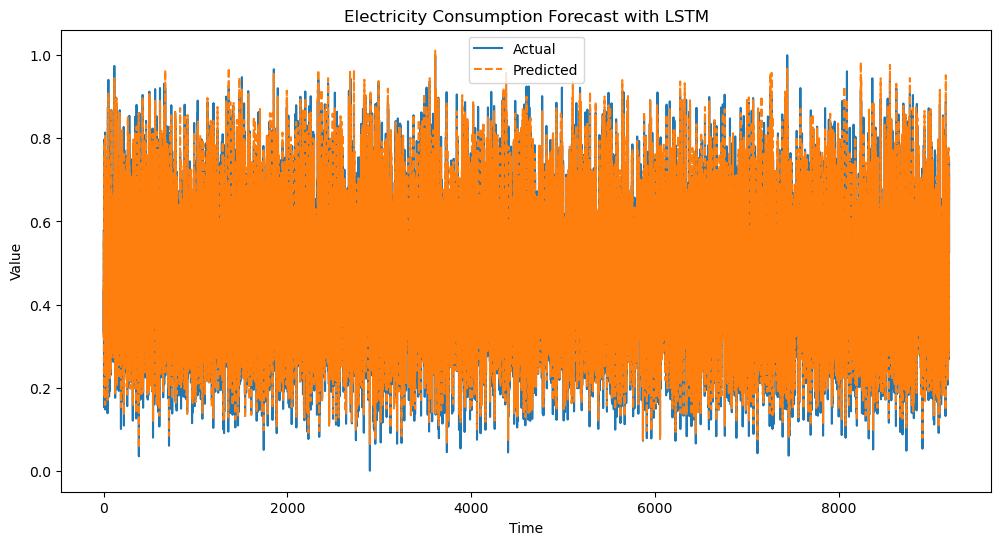

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the preprocessed data
f_data = pd.read_csv('preprocessed_electricity_data.csv')

# Function to prepare data for LSTM
def prepare_lstm_data(df, feature, lookback=5):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[feature]])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to [samples, timesteps, features]
    return X, y, scaler

# Function to create and train LSTM model
def train_lstm_model(X_train, y_train, input_shape, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate LSTM model and plot results
def evaluate_lstm_model(model, X_test, y_test, scaler, title):
    y_pred = model.predict(X_test)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_scaled = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    print(f"{title} - Mean Squared Error: {mse}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_scaled, label='Actual')
    plt.plot(y_pred_scaled, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for LSTM
X, y, scaler = prepare_lstm_data(f_data, 'Consumption', lookback=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LSTM model
lstm_model = train_lstm_model(X_train, y_train, (X_train.shape[1], 1))

# Evaluate LSTM model
evaluate_lstm_model(lstm_model, X_test, y_test, scaler, "Electricity Consumption Forecast with LSTM")


# Hybrid

C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smile\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/10


C:\Users\smile\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0023
Epoch 2/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013
Epoch 3/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013
Epoch 4/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012
Epoch 5/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0013
Epoch 6/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012
Epoch 7/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013
Epoch 8/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013
Epoch 9/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013
Epoch 10/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Hybrid ARIMA-ANN Forecast - Mean Squared Error: 0.0032451028392550397, Mean Absolute Error: 0.04369517914858571


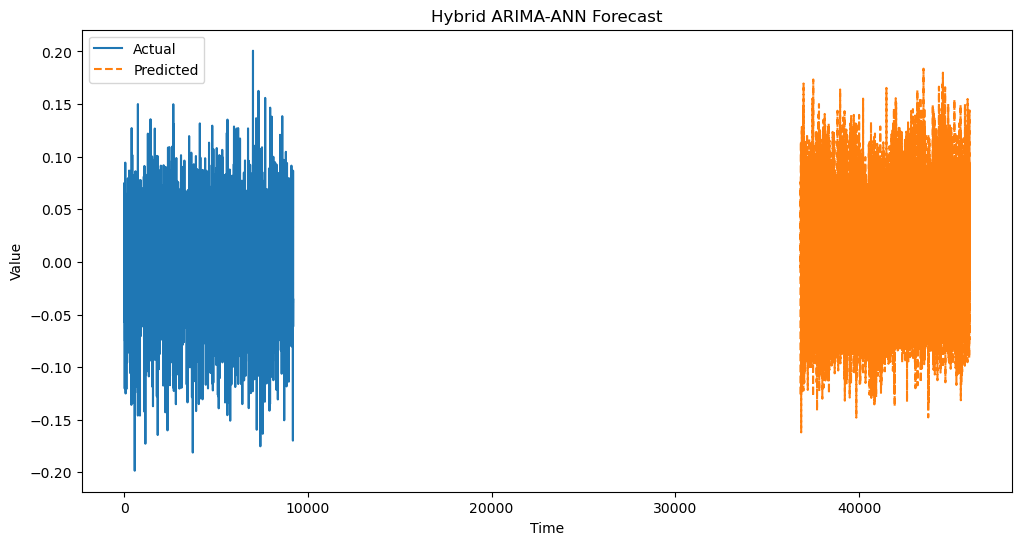

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Load data (update file paths as needed)
f_data = pd.read_csv('preprocessed_electricity_data.csv')

# Function to check stationarity
def test_stationarity(ts):
    adf_result = adfuller(ts)
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary': adf_result[1] < 0.05
    }

# Function to prepare data for ARIMA
def prepare_arima_data(df, feature):
    return df[[feature]].dropna()

# Function to create and train an ARIMA model
def train_arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit()
    return model_fit

# Function to create and train an ANN model
def train_ann_model(X_train, y_train, input_dim, epochs=10, batch_size=32):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{title} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data for ARIMA
f_data_for_arima = prepare_arima_data(f_data, 'Consumption_diff')
arima_model = train_arima_model(f_data_for_arima, order=(5, 1, 0))
arima_pred = arima_model.predict(start=0, end=len(f_data_for_arima)-1)
residuals = f_data_for_arima['Consumption_diff'] - arima_pred

# ANN model for residuals
scaler = StandardScaler()
X = scaler.fit_transform(arima_pred.values.reshape(-1, 1))
y = residuals.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ann_model = train_ann_model(X_train, y_train, input_dim=1)
ann_pred = ann_model.predict(X_test)

# Combine ARIMA and ANN predictions
combined_pred = arima_pred[-len(ann_pred):] + ann_pred.flatten()
evaluate_hybrid_model(y_test, combined_pred, "Hybrid ARIMA-ANN Forecast")
